In [10]:
!pip install -q opendatasets

## Import required package

In [11]:
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import time
import opendatasets as od

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.layers import Conv2DTranspose, Conv2D, ZeroPadding2D, Activation, LeakyReLU,\
                                    ReLU, UpSampling2D, Flatten, Dense, BatchNormalization, Reshape, Dropout
from tensorflow.keras.activations import tanh, sigmoid
from tensorflow.keras.optimizers import Adam
from IPython import display

## Hyperparameter Configuration

In [12]:
# The configuration will follow the set up in the paper

# Dataset hyperparameter configuration
BATCH_SIZE = 128
BUFFER_SIZE = 60000

# Normal probability distribution configuration
mean = 0.0
std = 1.0

# LeakyRELU slope of the leak
slope = 0.2

# Optimizer configuration
learning_rate = 2e-5
momentum = 0.5

# Dimension of input vector to the generator
NOISE_DIMS = 100

# Image settings
CHANNELS_IMG = 3
IMG_SIZE = 64

## Prepare data

In [13]:
# Dataset link : https://www.kaggle.com/datasets/kvpratama/pokemon-images-dataset
od.download_kaggle_dataset("https://www.kaggle.com/datasets/jeffheaton/glasses-or-no-glasses", '.')

Skipping, found downloaded files in "./glasses-or-no-glasses" (use force=True to force download)


In [14]:
dataset = image_dataset_from_directory('/content/glasses-or-no-glasses/faces-spring-2020',
                                       labels=None,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True,
                                       image_size=(IMG_SIZE , IMG_SIZE),
                                       )

Found 5000 files belonging to 1 classes.


In [15]:
def prepare_dataset(dataset, batch_size, buffer_size, shuffle=True):
    dataset = dataset.batch(batch_size, drop_remainder=True)
    if shuffle:
        dataset = dataset.shuffle(buffer_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

def preprocessing_image(image):
    # Resize the image to 64x64
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    # Scale value of image to range [-1, 1]
    image = tf.cast(image, tf.float32)
    image = image / 127.5 - 1.0

    return image

dataset = dataset.map(preprocessing_image)
#dataset = prepare_dataset(dataset, batch_size=BATCH_SIZE, buffer_size=BUFFER_SIZE, shuffle=True)

(128, 64, 64, 3)


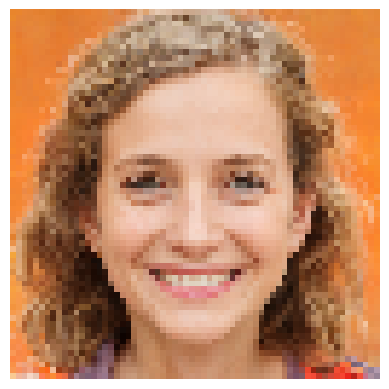

In [16]:
for image in dataset:
    print(image.shape)
    plt.imshow(((image[1] + 1.0) * 127.5).numpy().astype('uint8'))
    plt.axis('off')
    break

## Implement the generator

In [17]:
class Generator(keras.Model):
    def __init__(self):
        super(Generator, self).__init__()
        self.net = keras.models.Sequential(
            [
                # Input : Batch_size x noise_dims
                # We can apply the Fully Connected layers to the first layer of generator
                # and reshape it to 4-d tensor as the start of convolutional stacks.
                # We don't apply BatchNormalization layer to output of Generator.
                Dense(4 * 4 * 1024, activation='relu'),
                Reshape((4, 4, 1024)), # image 4x4x1024
                self._block(512, (5, 5), (2, 2), 'same'), # image 8x8x512
                self._block(256, (5, 5), (2, 2), 'same'), # image 16x16x256
                self._block(128, (5, 5), (2, 2), 'same'), # image 32x32x128
                Conv2DTranspose(filters=CHANNELS_IMG, kernel_size=5, strides=2, padding='same'),
                Activation(tanh)
            ]
        )

    def _block(self, filters, kernel_size, strides, padding):
        return keras.models.Sequential(
            [
                #UpSampling2D(size=size),
                Conv2DTranspose(filters=filters,
                       kernel_size=kernel_size,
                       strides=strides,
                       padding=padding, activation='relu'),
                BatchNormalization(momentum=0.8),
                ReLU()
            ]
        )

    def call(self, x, training=True):
        return self.net(x)

In [18]:
# Check whether the output of generator have the right shape
random_input = tf.random.normal([BATCH_SIZE, NOISE_DIMS])

test_generator = Generator()
test_output = test_generator(random_input, training=False)
test_output.shape

TensorShape([128, 64, 64, 3])

## Implement the discriminator

In [19]:
class Discriminator(keras.Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.net = keras.models.Sequential(
            [
                # Input shape will be batch_size x 64 x 64 x 3.
                # We don't apply BatchNormalization layer to the input of Discriminator
                self._block(filters=128, kernel_size=(5, 5), strides=2, padding='same', batch_norm=False),
                self._block(filters=256, kernel_size=(5, 5), strides=2, padding='same', batch_norm=True),
                self._block(filters=512, kernel_size=(5, 5), strides=2, padding='same', batch_norm=True),
                self._block(filters=1024, kernel_size=(5, 5), strides=2, padding='same', batch_norm=True),
                # The image now is 4x4, after applying the conv2d below we will make it become 1x1
                # self._block(filters=1, kernel_size=(4, 4), strides=1, padding='valid', batch_norm=True),
                Flatten(),
                # The last layer will be fed to sigmoid output
                Dense(1, activation='sigmoid')
            ]
        )
    def _block(self, filters, kernel_size, strides, padding, batch_norm=False):
        # Define sub model
        sub_model = keras.models.Sequential()
        sub_model.add(Conv2D(filters=filters,
                       kernel_size=kernel_size,
                       strides=strides,
                       padding=padding))
        if batch_norm:
            sub_model.add(BatchNormalization(momentum=0.8))
        sub_model.add(LeakyReLU(alpha=slope))
        sub_model.add(Dropout(0.25))

        return sub_model

    def call(self, x, training=True):
        return self.net(x)

In [20]:
# Check whether the output of discriminator is right
H, W = 64, 64
test_image = tf.random.normal([BATCH_SIZE, H, W, CHANNELS_IMG])

test_discriminator = Discriminator()
test_output = test_discriminator(test_image, training=False)
test_output.shape

TensorShape([128, 1])

## Define loss function

In [21]:
def discriminator_loss(real_output, generated_output):
    return -tf.reduce_mean(tf.math.log(real_output) + tf.math.log(1-generated_output))

def generator_loss(generated_output):
    # This is a non-saturating loss. This will ensure the generator will have enough gradient at the beginning of
    # training.
    return -tf.reduce_mean(tf.math.log(generated_output))

## Train model

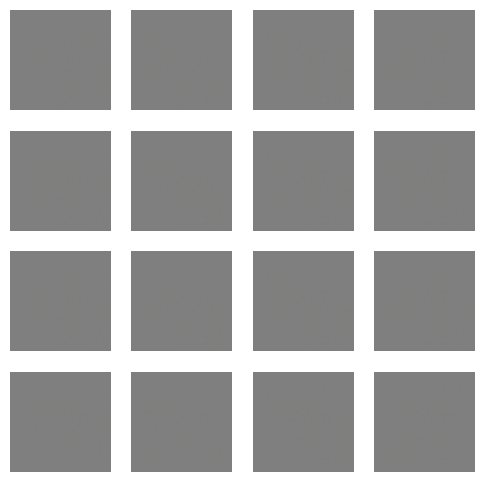

In [22]:
# Define optimizer
generator_optim = Adam(learning_rate=learning_rate, beta_1=momentum, beta_2=0.999)
discriminator_optim = Adam(learning_rate=learning_rate, beta_1=momentum, beta_2=0.999)

# Initialize model
generator = Generator()
discriminator = Discriminator()

# Create checkpoint
checkpoint_dir = './checkpoint'
checkpoint_prefix = os.path.join(checkpoint_dir, 'dcgan-ckpt')
checkpoint = tf.train.Checkpoint(generator=generator, discriminator=discriminator,
                                 generator_optim=generator_optim, discriminator_optim=discriminator_optim)

# Create test input
number_of_samples = 16
test_input = tf.random.normal([number_of_samples, NOISE_DIMS])

# Helper function for plot loss
def plot_loss(g_losses, d_losses):
    plt.plot(g_losses, label='Generator Loss')
    plt.plot(d_losses, label='Discriminator Loss')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Helper function for visualize data
def generate_and_visualize(test_input):
    output_images = generator(test_input, training=False)
    fig = plt.figure(figsize=(6, 6))
    for i in range(number_of_samples):
        plt.subplot(4, 4, i + 1)
        plt.imshow(((output_images[1] + 1.0) * 127.5).numpy().astype('uint8'))
        plt.axis('off')

    plt.show()

generate_and_visualize(test_input)

In [23]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [24]:
D_losses = []
G_losses = []
def train(real_dataset, epochs, test_input):
    for epoch in range(epochs):

        start = time.perf_counter()
        for images in real_dataset:
          noise_input = tf.random.normal([images.shape[0], NOISE_DIMS])
          with tf.GradientTape() as d_tape, tf.GradientTape() as g_tape:
              generated_image = generator(noise_input, training=True)

              # Inference
              generated_output = discriminator(generated_image, training=True)
              real_output = discriminator(images, training=True)

              # Calculate loss
              d_loss = discriminator_loss(real_output=real_output, generated_output=generated_output)
              g_loss = generator_loss(generated_output)

          # Calculate gradients
          g_grads = g_tape.gradient(g_loss, generator.trainable_variables)
          d_grads = d_tape.gradient(d_loss, discriminator.trainable_variables)

          # Update weights
          discriminator_optim.apply_gradients(zip(d_grads, discriminator.trainable_variables))
          generator_optim.apply_gradients(zip(g_grads, generator.trainable_variables))

          # Append loss for visualization
          G_losses.append(g_loss)
          D_losses.append(d_loss)

          print(d_loss, g_loss)

        # Monitor training process
        display.clear_output(wait=True)
        print(f'Traning epoch {epoch + 1} takes {time.perf_counter() - start} seconds')
        generate_and_visualize(test_input)

        plot_loss(G_losses, D_losses)

        # Save checkpoint
        if (epoch + 1) % 10 == 0:
            checkpoint.save(checkpoint_prefix)

    print('Done!')
    # Display the last result
    display.clear_output(wait=True)
    print(f'Traning epoch {epoch} takes {time.perf_counter() - start} seconds')
    generate_and_visualize(test_input)
    plot_loss(G_losses, D_losses)

Traning epoch 90 takes 186.3256914630001 seconds


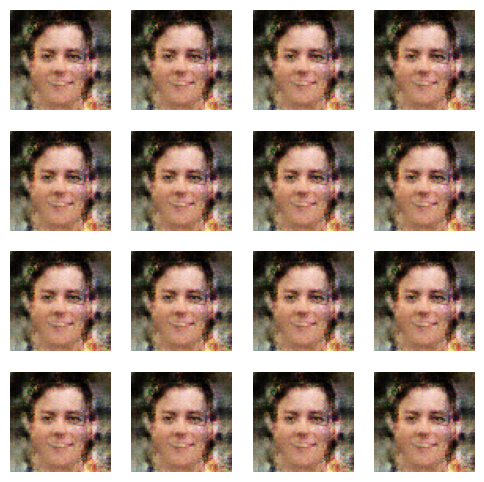

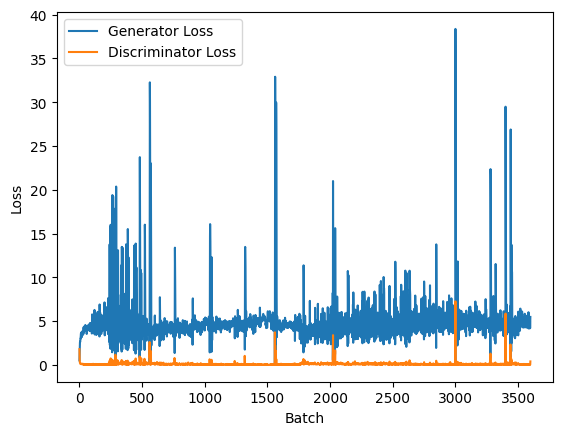

tf.Tensor(0.39024708, shape=(), dtype=float32) tf.Tensor(2.0627759, shape=(), dtype=float32)
tf.Tensor(0.061933123, shape=(), dtype=float32) tf.Tensor(10.373661, shape=(), dtype=float32)
tf.Tensor(0.102071084, shape=(), dtype=float32) tf.Tensor(12.790611, shape=(), dtype=float32)
tf.Tensor(0.11157939, shape=(), dtype=float32) tf.Tensor(10.987256, shape=(), dtype=float32)
tf.Tensor(0.059204046, shape=(), dtype=float32) tf.Tensor(7.8937654, shape=(), dtype=float32)
tf.Tensor(0.026367769, shape=(), dtype=float32) tf.Tensor(5.2072153, shape=(), dtype=float32)
tf.Tensor(0.103182934, shape=(), dtype=float32) tf.Tensor(3.7231061, shape=(), dtype=float32)
tf.Tensor(0.037769288, shape=(), dtype=float32) tf.Tensor(4.831832, shape=(), dtype=float32)
tf.Tensor(0.036116466, shape=(), dtype=float32) tf.Tensor(5.301203, shape=(), dtype=float32)
tf.Tensor(0.021406922, shape=(), dtype=float32) tf.Tensor(5.4787397, shape=(), dtype=float32)
tf.Tensor(0.0955516, shape=(), dtype=float32) tf.Tensor(4.474713

In [ ]:
EPOCHS = 100
train(real_dataset=dataset, epochs=EPOCHS, test_input=test_input)